In [238]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import statsmodels.api as sm

pd.set_option('display.max_rows',100)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [68]:
load_dotenv()
file_path = os.environ['data_path']

In [69]:
all_files = os.listdir(file_path)
all_files

['PRSA_Data_Aotizhongxin_20130301-20170228.csv',
 'PRSA_Data_Changping_20130301-20170228.csv',
 'PRSA_Data_Dingling_20130301-20170228.csv',
 'PRSA_Data_Dongsi_20130301-20170228.csv',
 'PRSA_Data_Guanyuan_20130301-20170228.csv',
 'PRSA_Data_Gucheng_20130301-20170228.csv',
 'PRSA_Data_Huairou_20130301-20170228.csv',
 'PRSA_Data_Nongzhanguan_20130301-20170228.csv',
 'PRSA_Data_Shunyi_20130301-20170228.csv',
 'PRSA_Data_Tiantan_20130301-20170228.csv',
 'PRSA_Data_Wanliu_20130301-20170228.csv',
 'PRSA_Data_Wanshouxigong_20130301-20170228.csv']

In [70]:
df = pd.read_csv(file_path+all_files[0])
df.columns = df.columns.str.lower()
df['ts'] = pd.to_datetime(df[['year','month','day','hour']])
df['date'] = pd.to_datetime(df[['year','month','day']])
print(df.shape)
df.head()

(35064, 20)


,no,year,month,day,hour,pm2.5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station,ts,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00,2013-03-01
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00,2013-03-01
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00,2013-03-01
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00,2013-03-01
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00,2013-03-01


In [71]:
# Changing units for CO - the data is microgram whereas the thresholds from the video are in mg
df['co'] = df['co']/1000

### Air Quality Index Calculation
[Reference for Calculation](https://www.youtube.com/watch?v=CFLClC-xxTQ)

In [72]:
df_aqi = pd.read_excel('aqi_ranges.xlsx')
df_aqi.columns = df_aqi.columns.str.lower()

df_aqi

,aqi_category,aqi_min,aqi_max,pm2.5_min,pm2.5_max,pm10_min,pm10_max,so2_min,so2_max,no2_min,no2_max,co_min,co_max,o3_min,o3_max
0,Good,0,50,0,30,0,50,0,40,0,40,0.0,1,0,50
1,Satisfactory,51,100,31,60,51,100,41,80,41,80,1.1,2,51,100
2,Moderately polluted,101,200,61,90,101,250,81,380,81,180,2.1,10,101,168
3,Poor,201,300,91,120,251,350,381,800,181,280,10.0,17,169,208
4,Very poor,301,400,121,250,351,430,801,1600,281,400,17.0,34,209,748
5,Severe,401,500,250,10000,430,10000,1600,10000,400,10000,34.0,10000,748,10000


In [73]:
### Calculating the sub-indexes for all pollutants
pollutants = ['pm2.5','pm10','so2','no2','co','o3']
df_c = df.copy()

for x in pollutants:
    col_to_partition = df[x].tolist()
    part_ranges = df_aqi[x+'_min'].tolist() + [1000000]
    
    aqi_min = pd.cut(col_to_partition, bins=part_ranges, labels=df_aqi['aqi_min'].tolist())
    aqi_max = pd.cut(col_to_partition, bins=part_ranges, labels=df_aqi['aqi_max'].tolist())
    pol_min = pd.cut(col_to_partition, bins=part_ranges, labels=df_aqi[x+'_min'].tolist())
    pol_max = pd.cut(col_to_partition, bins=part_ranges, labels=df_aqi[x+'_max'].tolist())
    df_temp = pd.DataFrame(data={
        'i_min':aqi_min,
        'i_max':aqi_max,
        'c_min':pol_min,
        'c_max':pol_max,
        'c_obs':col_to_partition},
        dtype='float64') # Change if handling lots of data
    c = x + '_si' # Pollutant sub-index column
    df_temp[c] = df_temp['c_obs'] - df_temp['c_min']
    df_temp[c] = df_temp[c]*(df_temp['i_max'] - df_temp['i_min'])
    df_temp['den'] = (df_temp['c_max'] - df_temp['c_min'])
    df_temp.loc[df_temp['den'] == 0,'den'] = 1 # To avoid zero division
    df_temp[c] = df_temp[c]/df_temp['den']
    df_temp[c] = df_temp[c] + df_temp['i_min']
    df_c[c] = df_temp[c]

df_c

,no,year,month,day,hour,pm2.5,pm10,so2,no2,co,...,wspm,station,ts,date,pm2.5_si,pm10_si,so2_si,no2_si,co_si,o3_si
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,0.3,...,4.4,Aotizhongxin,2013-03-01 00:00:00,2013-03-01,6.666667,4.0,5.00,8.750000,15.0,77.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,0.3,...,4.7,Aotizhongxin,2013-03-01 01:00:00,2013-03-01,13.333333,8.0,5.00,8.750000,15.0,77.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,0.3,...,5.6,Aotizhongxin,2013-03-01 02:00:00,2013-03-01,11.666667,7.0,6.25,12.500000,15.0,73.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,0.3,...,3.1,Aotizhongxin,2013-03-01 03:00:00,2013-03-01,10.000000,6.0,13.75,13.750000,15.0,72.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,0.3,...,2.0,Aotizhongxin,2013-03-01 04:00:00,2013-03-01,5.000000,3.0,15.00,15.000000,15.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,0.4,...,2.4,Aotizhongxin,2017-02-28 19:00:00,2017-02-28,20.000000,29.0,6.25,43.750000,20.0,95.0
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,0.5,...,0.9,Aotizhongxin,2017-02-28 20:00:00,2017-02-28,21.666667,37.0,8.75,56.025641,25.0,81.0
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,0.7,...,1.1,Aotizhongxin,2017-02-28 21:00:00,2017-02-28,26.666667,37.0,12.50,82.410256,35.0,58.0
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,0.7,...,1.2,Aotizhongxin,2017-02-28 22:00:00,2017-02-28,35.000000,44.0,15.00,107.000000,35.0,35.0


In [74]:
# The AQI is the max of all the sub-indexes
pol_si_names = [i+'_si' for i in pollutants]
df_c['aqi'] = df_c[pol_si_names].apply(max,axis=1)
df_c['dominant'] = df_c[pol_si_names].fillna(-1).apply(lambda x: pol_si_names[np.argmax(x)],axis=1)
df_c.sample(8)

,no,year,month,day,hour,pm2.5,pm10,so2,no2,co,...,ts,date,pm2.5_si,pm10_si,so2_si,no2_si,co_si,o3_si,aqi,dominant
5660,5661,2013,10,22,20,83.0,87.0,10.0,65.0,0.9,...,2013-10-22 20:00:00,2013-10-22,176.103448,87.000000,12.50,81.153846,45.000000,2.000000,176.103448,pm2.5_si
1567,1568,2013,5,5,7,156.0,200.0,39.0,99.0,1.0,...,2013-05-05 07:00:00,2013-05-05,327.860465,166.778523,48.75,119.000000,50.000000,3.000000,327.860465,pm2.5_si
22769,22770,2015,10,5,17,256.0,279.0,13.0,83.0,2.0,...,2015-10-05 17:00:00,2015-10-05,401.060923,229.000000,16.25,103.000000,100.000000,306.877551,401.060923,pm2.5_si
14339,14340,2014,10,19,11,343.0,499.0,17.0,187.0,3.3,...,2014-10-19 11:00:00,2014-10-19,401.944308,401.713793,21.25,207.000000,116.037975,2.000000,401.944308,pm2.5_si
30693,30694,2016,8,30,21,38.0,58.0,3.0,49.0,1.0,...,2016-08-30 21:00:00,2016-08-30,62.827586,58.000000,3.75,61.051282,50.000000,197.044776,197.044776,o3_si
25614,25615,2016,2,1,6,12.0,22.0,12.0,32.0,0.7,...,2016-02-01 06:00:00,2016-02-01,20.000000,22.000000,15.00,40.000000,35.000000,39.000000,40.000000,no2_si
17303,17304,2015,2,19,23,121.0,121.0,21.0,27.0,1.0,...,2015-02-19 23:00:00,2015-02-19,303.413793,114.288591,26.25,33.750000,50.000000,67.000000,303.413793,pm2.5_si
20493,20494,2015,7,2,21,16.0,47.0,2.0,74.0,0.6,...,2015-07-02 21:00:00,2015-07-02,26.666667,47.000000,2.50,92.461538,30.000000,31.000000,92.461538,no2_si


In [148]:
df_c.date.describe()

count                  35064
mean     2015-03-01 00:00:00
min      2013-03-01 00:00:00
25%      2014-03-01 00:00:00
50%      2015-03-01 00:00:00
75%      2016-02-29 00:00:00
max      2017-02-28 00:00:00
Name: date, dtype: object

### Data Preparation - R1

In [75]:
# -45%360

In [76]:
# https://www.quora.com/What-direction-is-a-NNW-wind-coming-from
# Converting wind direction to angles
# Need to doc
wd = df.wd.dropna().unique().tolist()
wd_orig = wd.copy()
angles = {} # Measured clockwise from North
d = {'N':1,'S':-1,'E':-1,'W':1}
vert_angles = {'N':0,'S':180}
hor_angles = {'E':45, 'W':-45}

wd_angles = dict(zip(wd,[0]*len(wd)))
for direction in wd:
    dd = 0
    if len(direction) == 1:
        dd += vert_angles.get(direction,0) + hor_angles.get(direction,0)*2
    if len(direction) == 2:
        dd += vert_angles.get(direction[0],0) + hor_angles.get(direction[1],0)*d.get(direction[0],1)
    if len(direction) == 3:
        dd += vert_angles.get(direction[1],0) + hor_angles.get(direction[2],0)*d.get(direction[1],1)
        dd = dd%360
        inc = (vert_angles.get(direction[0],0) + (hor_angles.get(direction[0],0)*2)%360)/45
        inc = 8 if inc == 0 and dd > 180 else inc
        inc2 = inc - dd/45
        dd += 22.5*inc2

        # print(direction,dd,inc,dd/45,inc2)
        # print(22.5*(((((vert_angles.get(direction[0],0)) + (hor_angles.get(direction[0],0)*2))%360)/45) - (dd/45)))
        # dd += 22.5*(((((vert_angles.get(direction[0],0)) + (hor_angles.get(direction[0],0)*2))%360)/45) - (dd/45))
        # print(direction, ((((vert_angles.get(direction[0],0)) + (hor_angles.get(direction[0],0)*2))%360)/45))
        # print(vert_angles.get(direction[1],0) + hor_angles.get(direction[2],0)*d.get(direction[1],1))

    if dd < 0:
        dd = 360 + dd
    wd_angles[direction] = dd
wd_angles = pd.DataFrame({'wd':wd_angles.keys(),'wd_angle':wd_angles.values()})
wd_angles

,wd,wd_angle
0,NNW,337.5
1,N,0.0
2,NW,315.0
3,NNE,22.5
4,ENE,67.5
5,E,90.0
6,NE,45.0
7,W,270.0
8,SSW,202.5
9,WSW,247.5


In [77]:
# East (+ve in 1st, -ve in 2nd)
# North (-ve in 1st, +ve in 4th)
# South (+ve in 2nd, -ve in 3rd)
# West (+ve in 3rd, -ve in 4th)

In [78]:
print(df_c.shape)
df_c = df_c.merge(wd_angles,on='wd',how='left')
print(df_c.shape)

(35064, 28)
(35064, 29)


In [79]:
df_c = df_c.drop(columns=['no'])

### EDA - R1
#### Data issues/Sensor outages

In [16]:
df_c.head()

,year,month,day,hour,pm2.5,pm10,so2,no2,co,o3,...,ts,date,pm2.5_si,pm10_si,so2_si,no2_si,co_si,aqi,dominant,wd_angle
0,2013,3,1,0,4.0,4.0,4.0,7.0,0.3,77.0,...,2013-03-01 00:00:00,2013-03-01,6.666667,4.0,5.00,8.75,15.0,15.0,co_si,337.5
1,2013,3,1,1,8.0,8.0,4.0,7.0,0.3,77.0,...,2013-03-01 01:00:00,2013-03-01,13.333333,8.0,5.00,8.75,15.0,15.0,co_si,0.0
2,2013,3,1,2,7.0,7.0,5.0,10.0,0.3,73.0,...,2013-03-01 02:00:00,2013-03-01,11.666667,7.0,6.25,12.50,15.0,15.0,co_si,337.5
3,2013,3,1,3,6.0,6.0,11.0,11.0,0.3,72.0,...,2013-03-01 03:00:00,2013-03-01,10.000000,6.0,13.75,13.75,15.0,15.0,co_si,315.0
4,2013,3,1,4,3.0,3.0,12.0,12.0,0.3,72.0,...,2013-03-01 04:00:00,2013-03-01,5.000000,3.0,15.00,15.00,15.0,15.0,so2_si,0.0


In [17]:
# Checking nulls
df_c.isnull().sum()

year           0
month          0
day            0
hour           0
pm2.5        925
pm10         718
so2          935
no2         1023
co          1776
o3          1719
temp          20
pres          20
dewp          20
rain          20
wd            81
wspm          14
station        0
ts             0
date           0
pm2.5_si     925
pm10_si      718
so2_si       935
no2_si      1023
co_si       1776
aqi          925
dominant       0
wd_angle      81
dtype: int64

In [18]:
# Certain months have more outliers than the rest. Seems worth checking
df_c[pollutants].isnull().groupby([df_c['year'],df_c['month']]).sum().reset_index()

,year,month,pm2.5,pm10,so2,no2,co
0,2013,3,0,1,9,2,80
1,2013,4,0,0,2,7,29
2,2013,5,2,0,0,0,86
3,2013,6,3,0,13,8,214
4,2013,7,0,2,2,2,40
5,2013,8,1,0,4,21,158
6,2013,9,1,2,0,6,10
7,2013,10,1,0,0,1,56
8,2013,11,2,0,0,0,10
9,2013,12,1,0,71,2,181


In [19]:
# Appears as if the sensors went down sometime in December 2014
# Criterion: If more than half of the observations for any pollutant are null, then it should be classified as a data anomaly
sort_var = 'co'
df_c[pollutants].isnull().groupby([df_c['year'],df_c['month'],df_c['day']]).sum().reset_index().sort_values(sort_var,ascending=False).head(20)

,year,month,day,pm2.5,pm10,so2,no2,co
423,2014,4,28,24,24,24,24,24
660,2014,12,21,24,24,24,24,24
81,2013,5,21,0,0,0,0,24
669,2014,12,30,24,24,24,24,24
667,2014,12,28,24,24,24,24,24
661,2014,12,22,24,24,24,24,24
289,2013,12,15,0,0,0,0,24
290,2013,12,16,0,0,0,0,24
291,2013,12,17,0,0,0,0,24
292,2013,12,18,1,0,0,0,24


In [20]:
# Checking for failure correlations
failures = df_c[pollutants].isnull().groupby([df_c['year'],df_c['month'],df_c['day']]).sum().reset_index().sort_values(sort_var,ascending=False)
failures['correlated_failures'] = failures[pollutants].apply(np.prod,axis=1)
failures['correlated_failures'] = failures['correlated_failures']**(1/len(pollutants))
failures['correlated_failures'].value_counts().reset_index().sort_values('correlated_failures',ascending=False)
# Observations which do not have a fractional part are more likely to denote observations representing correlated failures
# This is the most strict criteria for correlation; other combinations of the correlates may exist (or one can check the exhaused 2*number of pollutants)
# So this is something to watch out for
# Not sure what the failures represent though. Appear to be outages

,correlated_failures,count
2,24.000000,15
20,18.000000,1
19,17.000000,1
17,14.000000,1
18,13.512961,1
16,11.373727,1
21,9.191661,1
22,8.407171,1
13,8.000000,2
35,7.620793,1


In [21]:
# There are a total of 1340 instances where at least one sensor had no failure reading/missing value
# Observations which are perfectly clean i.e. days on which no sensors had missing values
clean_obs = df_c[pollutants].isnull().groupby(df_c['date']).sum().reset_index()
clean_obs = clean_obs[pollutants].apply(sum,axis=1).reset_index().rename(columns={0:'total_failures'}).total_failures.value_counts().reset_index()
clean_obs = clean_obs.sort_values('total_failures').reset_index(drop=True)
clean_obs['cumsum'] = clean_obs['count'].cumsum()
clean_obs['cumperc'] = clean_obs['cumsum']/clean_obs['count'].sum()
print('Total days',clean_obs['count'].sum())
clean_obs
# Total 992 days in which absolutely none of the pollutants have any missing values

Total days 1461


,total_failures,count,cumsum,cumperc
0,0,992,992,0.678987
1,1,147,1139,0.779603
2,2,46,1185,0.811088
3,3,33,1218,0.833676
4,4,17,1235,0.845311
5,5,47,1282,0.877481
6,6,20,1302,0.891170
7,7,13,1315,0.900068
8,8,6,1321,0.904175
9,9,7,1328,0.908966


In [22]:
# 1393 days (out of 1461) in which the data may be sufficient (more than 12 observations for all sensors)
clean_obs = df_c[pollutants].isnull().groupby(df_c['date']).sum().reset_index()
clean_obs = clean_obs[pollutants].map(lambda x: 0 if x < 12 else 1).apply(sum,axis=1).reset_index(drop=True)
(clean_obs == 0).sum()

np.int64(1393)

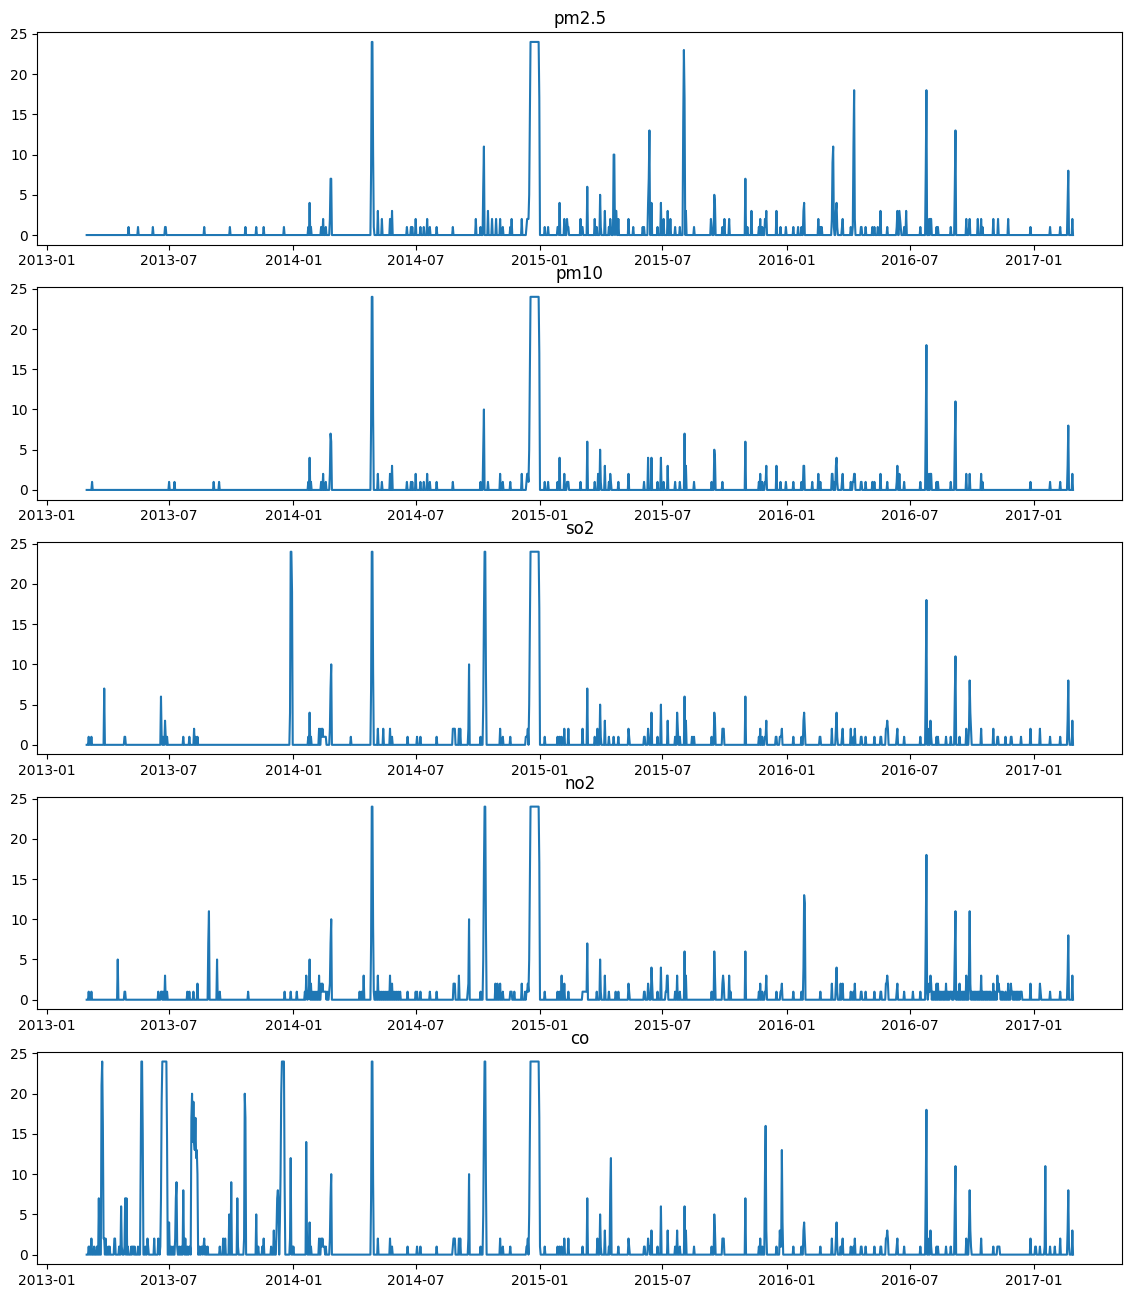

In [23]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html#stacking-subplots-in-one-direction
clean_obs = df_c[pollutants].isnull().groupby(df_c['date']).sum().reset_index()

fig, axs = plt.subplots(len(pollutants), figsize=(14,16))
# fig.suptitle('Pollutant anomalies over time')
for i in range(len(pollutants)):
    axs[i].plot(clean_obs['date'],clean_obs[pollutants[i]])
    axs[i].set_title(pollutants[i])

# Further indication that sensor failures tend to be correlated

### EDA - R2
#### AQI and sensor values

In [302]:
sensor_ixs = [x+'_si' for x in pollutants] + ['aqi']
sensor_ixs

['pm2.5_si', 'pm10_si', 'so2_si', 'no2_si', 'co_si', 'aqi']

In [303]:
df_c[sensor_ixs].describe()

,pm2.5_si,pm10_si,so2_si,no2_si,co_si,aqi
count,34139.000000,34346.000000,34129.000000,34041.000000,33288.000000,34139.000000
mean,152.177848,98.415159,20.979301,72.173905,53.652466,165.041701
std,130.628334,76.067089,25.222199,42.690448,36.363712,122.786876
min,5.000000,2.000000,0.357000,2.500000,5.000000,5.000000
25%,36.666667,38.000000,3.750000,37.500000,25.000000,62.000000
50%,96.620690,87.000000,11.250000,66.076923,45.000000,118.068966
75%,279.517241,136.879195,26.250000,102.000000,72.777778,282.931034
max,407.579692,406.731034,187.086957,308.487395,200.000000,407.579692


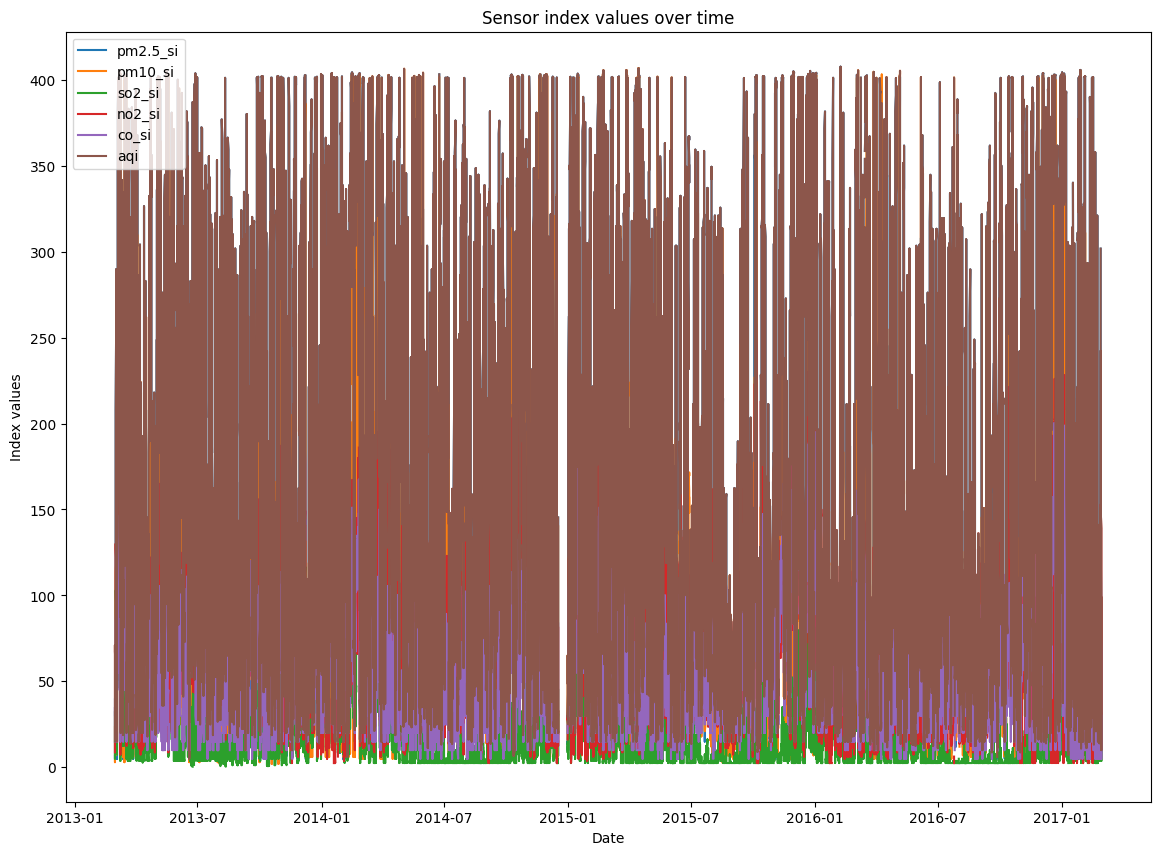

In [310]:
# https://stackoverflow.com/questions/33185037/how-to-set-default-colormap-in-matplotlib
plt.figure(figsize=(14,10))
for ix in sensor_ixs:
    plt.plot(df_c['date'], df_c[ix], label =ix)

plt.rcParams['image.cmap']='plasma'
plt.xlabel("Date")
plt.ylabel("Index values")
plt.legend()
plt.title('Sensor index values over time')
plt.show()

# Not as interesting as I assumed. Checking sensor values

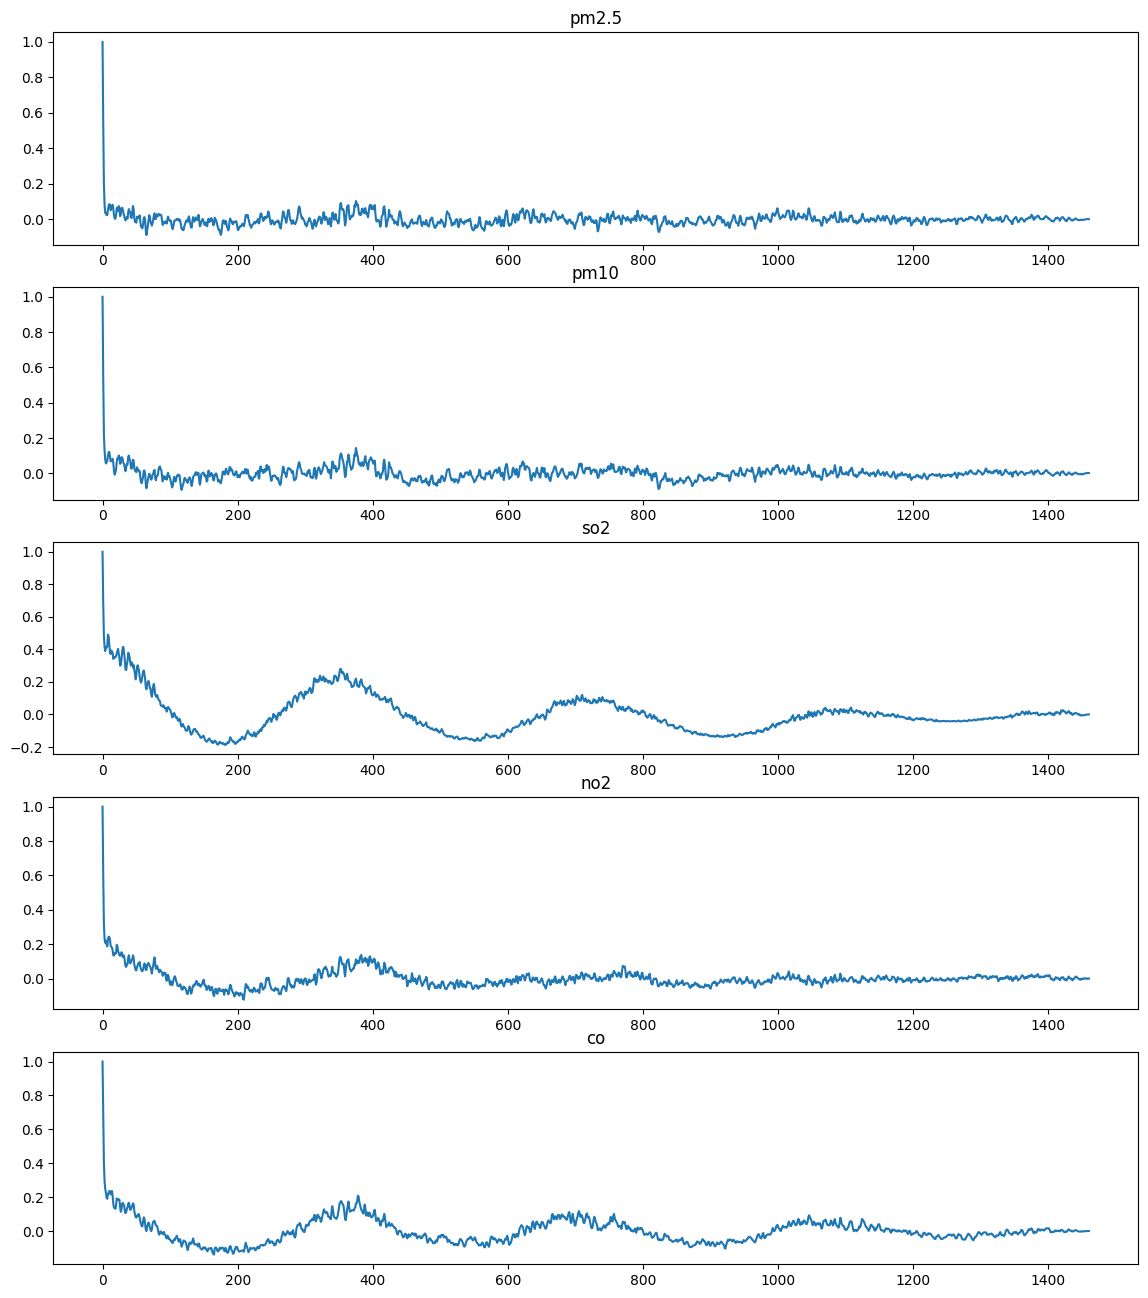

In [335]:
# Checking sensor ACFs
# https://www.scicoding.com/4-ways-of-calculating-autocorrelation-in-python/
s_datewise = df_c[pollutants].fillna(-1).groupby(df_c['date']).mean().reset_index()
lags = range(s_datewise.shape[0]) # range(91) # range(s_datewise.shape[0]) # range(15)

fig, axs = plt.subplots(len(pollutants), figsize=(14,16))
# fig.suptitle('Pollutant ACF')
for i in range(len(pollutants)):
    acorr = sm.tsa.acf(s_datewise[pollutants[i]].fillna(-1), nlags = len(lags)-1)
    axs[i].plot(lags,acorr.tolist())
    axs[i].set_title(pollutants[i])
    if len(lags) > 30 and len(lags) < 400:
        axs[i].set_xticks(range(0,len(lags),30))

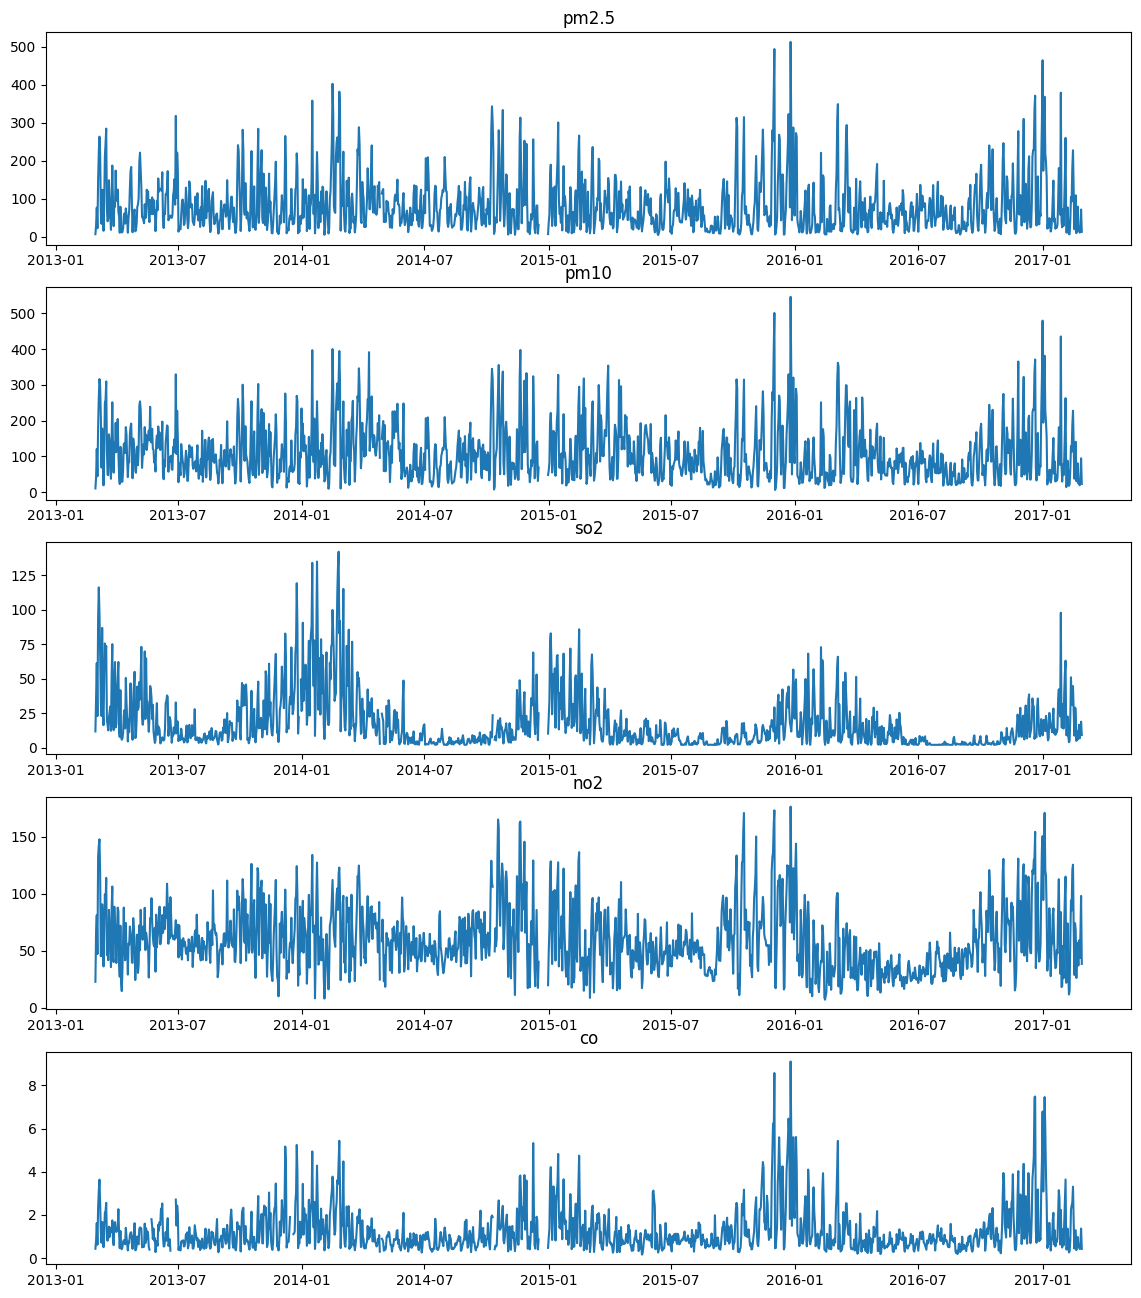

In [313]:
# Checking sensor values
s_datewise = df_c[pollutants].groupby(df_c['date']).mean().reset_index()

fig, axs = plt.subplots(len(pollutants), figsize=(14,16))
# fig.suptitle('Pollutant values over time')
for i in range(len(pollutants)):
    axs[i].plot(s_datewise['date'],s_datewise[pollutants[i]])
    axs[i].set_title(pollutants[i])

In [447]:
from statsmodels.tsa.seasonal import STL

x = pd.Series(
    s_datewise['co'].fillna(-1).tolist(), index=s_datewise['date'].tolist(), name="co"
)
# x = (x - x.shift(1)).dropna()
x[x==0] = 0.01

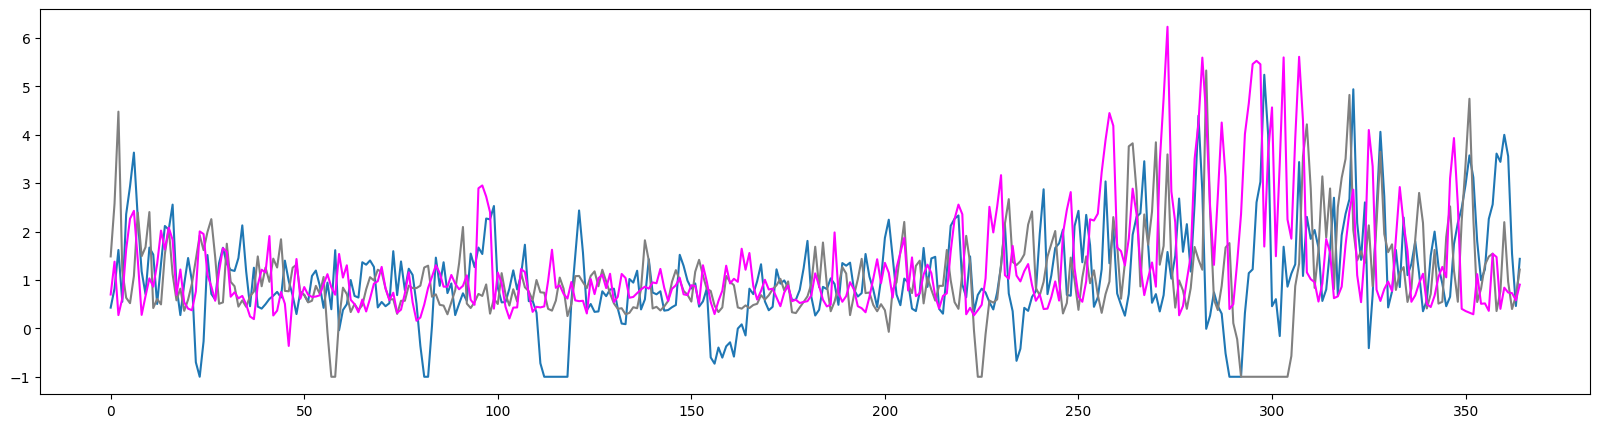

In [476]:
plt.figure(figsize=(20,5))

x = s_datewise[['co','date']].sort_values('date').drop(columns='date').reset_index()
plt.plot(x.iloc[0:365,0]%365,x.iloc[0:365,1])
plt.plot(x.iloc[365:365*2,0]%365,x.iloc[365:365*2,1],c='gray')
plt.plot(x.iloc[365*2:365*3,0]%365,x.iloc[365*2:365*3,1],c='magenta')

In [465]:
# pd.DataFrame(x.reset_index()).plot('index','co')

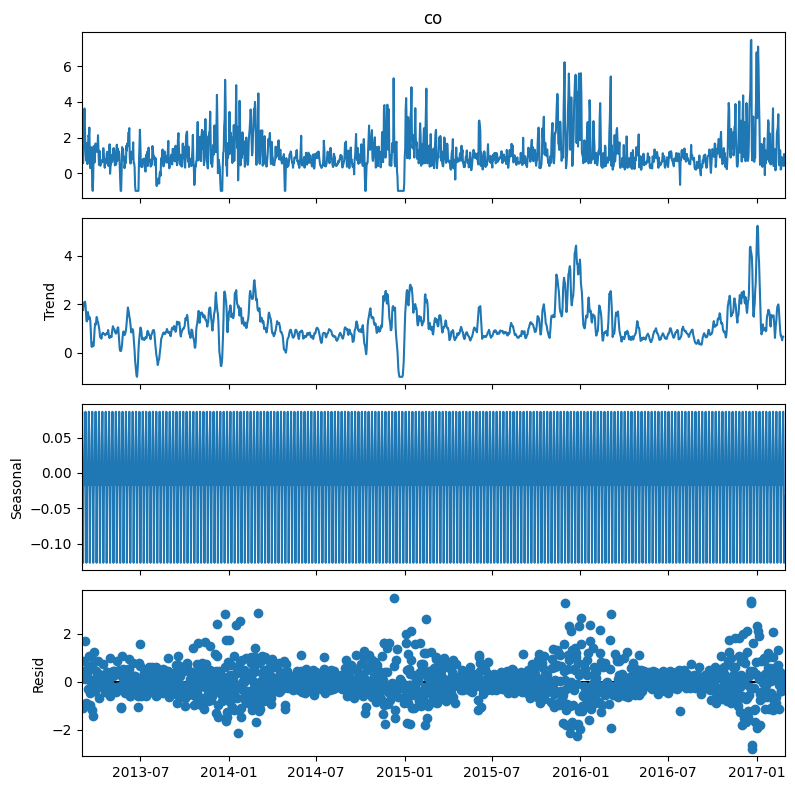

In [449]:
from statsmodels.tsa.seasonal import seasonal_decompose
# stl = STL(x, seasonal=365, trend=15)
# # stl = STL(x)
# res = stl.fit()
result = seasonal_decompose(x,model='additive')
fig = result.plot()
plt.rc("figure", figsize=(8,8))

In [380]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(x)

Results of Dickey-Fuller Test:
Test Statistic                   -4.747178
p-value                           0.000069
#Lags Used                       20.000000
Number of Observations Used    1440.000000
Critical Value (1%)              -3.434899
Critical Value (5%)              -2.863549
Critical Value (10%)             -2.567840
dtype: float64


In [24]:
df_c.columns

Index(['year', 'month', 'day', 'hour', 'pm2.5', 'pm10', 'so2', 'no2', 'co',
       'o3', 'temp', 'pres', 'dewp', 'rain', 'wd', 'wspm', 'station', 'ts',
       'date', 'pm2.5_si', 'pm10_si', 'so2_si', 'no2_si', 'co_si', 'aqi',
       'dominant', 'wd_angle'],
      dtype='object')

<Axes: xlabel='pm2.5', ylabel='pm10'>

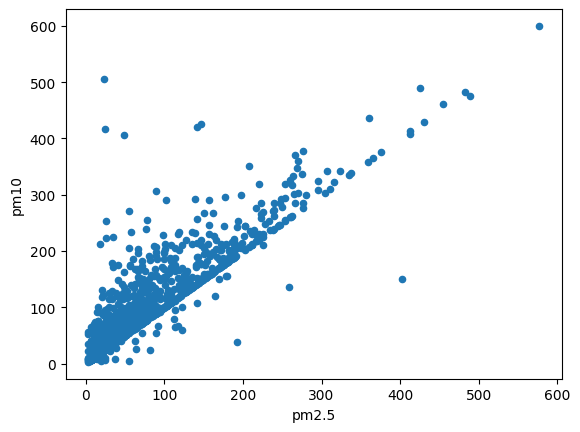

In [63]:
df_c.sample(1000).plot('pm2.5','pm10', kind='scatter')

<Axes: xlabel='temp', ylabel='o3'>

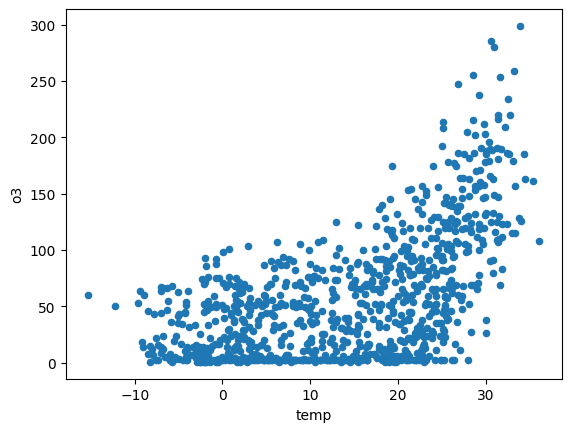

In [30]:
df_c.sample(1000).plot('temp','o3', kind='scatter')

### EDA - R3

Checking stationarity to determine how adaptive thresholding should be done

In [65]:
df_c[pollutants].describe()

,pm2.5,pm10,so2,no2,co
count,34139.000000,34346.000000,34129.000000,34041.000000,33288.000000
mean,82.773611,110.060391,17.375901,59.305833,1.262945
std,82.135694,95.223005,22.823017,37.116200,1.221436
min,3.000000,2.000000,0.285600,2.000000,0.100000
25%,22.000000,38.000000,3.000000,30.000000,0.500000
50%,58.000000,87.000000,9.000000,53.000000,0.900000
75%,114.000000,155.000000,21.000000,82.000000,1.500000
max,898.000000,984.000000,341.000000,290.000000,10.000000


In [103]:
pollutants

['pm2.5', 'pm10', 'so2', 'no2', 'co', 'o3']

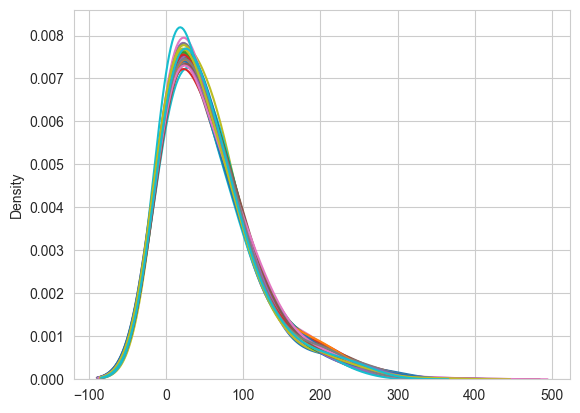

In [119]:
p = 'o3'
for i in range(40):
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(df_c.sample(1000)[p]), bw_method=0.5)

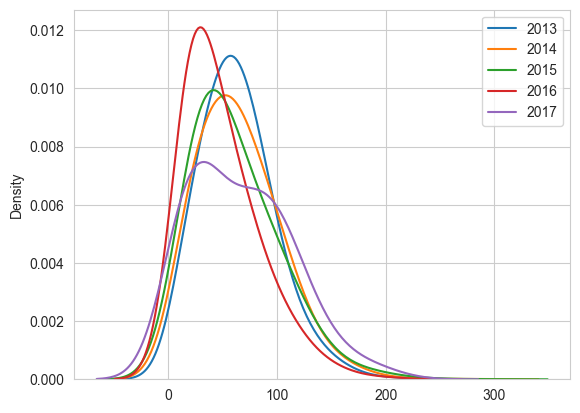

In [127]:
for i in df_c['year'].unique().tolist():
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(df_c.loc[df_c['year']==i,p]), bw_method=0.5, label=i)
plt.legend()

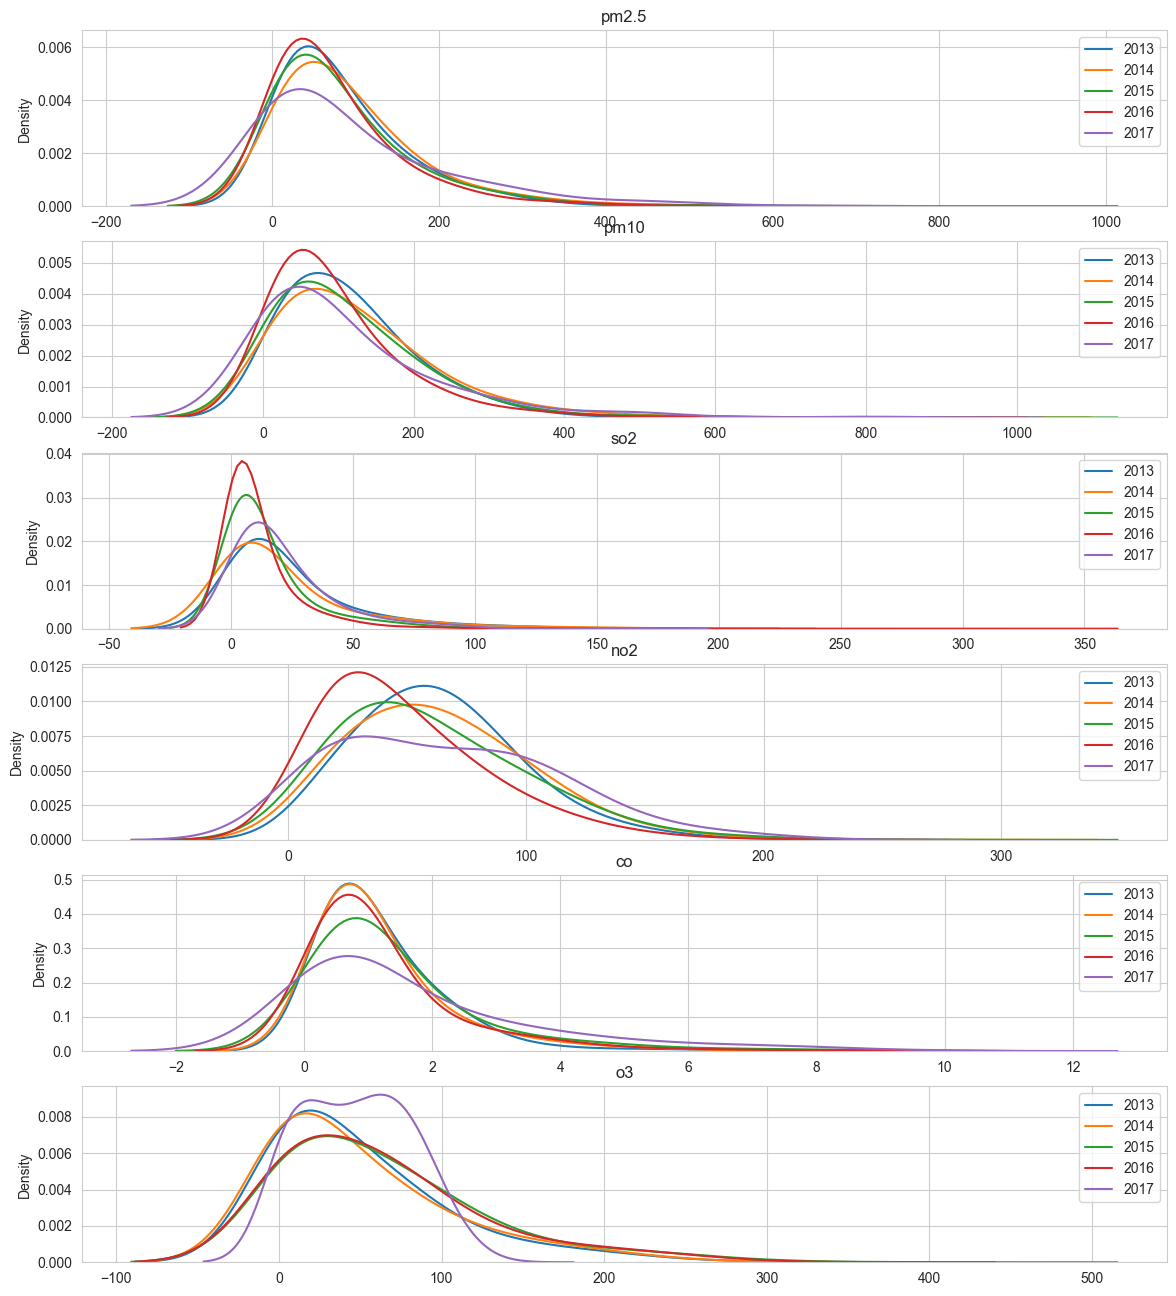

In [147]:
# The mean and SD tends to fluctuate
# Something is wrong with O3 and NO2 in 2017 (possibly because of incomplete year and seasonality?)
fig, axs = plt.subplots(len(pollutants), figsize=(14,16))
k = 0
years = df_c['year'].unique().tolist()
for p in pollutants:
    for i in years:
        sns.set_style('whitegrid')
        sns.kdeplot(np.array(df_c.loc[df_c['year']==i,p]), bw_method=0.5, label=i, ax=axs[k]).set_title(p)
    axs[k].legend(years)
    k+=1

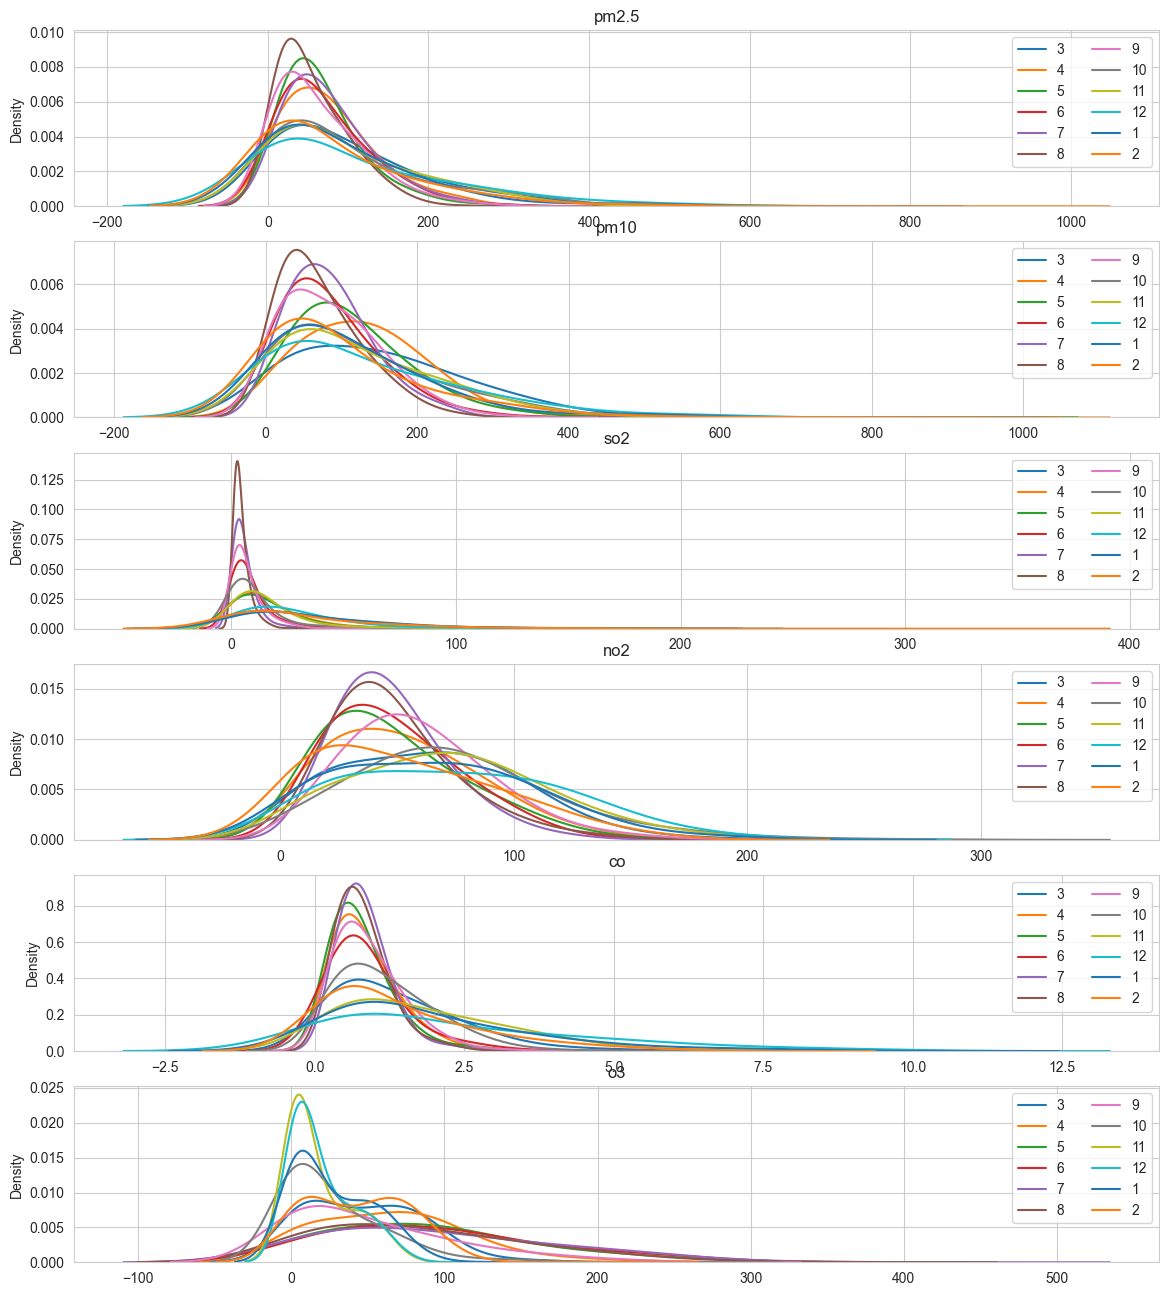

In [154]:
#  Plotting by month
fig, axs = plt.subplots(len(pollutants), figsize=(14,16))
k = 0
months = [int(m) for m in df_c['month'].unique().tolist()]
for p in pollutants:
    for i in years:
        sns.set_style('whitegrid')
        sns.kdeplot(np.array(df_c.loc[df_c['month']==i,p]), bw_method=0.5, label=i, ax=axs[k]).set_title(p)
    axs[k].legend(months, loc=1, ncols=2)
    k+=1

# Very interesting - the variance seems to vary a lot by month, which adds up with what we saw in terms of seasonality
# OR perhaps some months vary a lot across the years and others don't
# In general, it would be safe to assume that the distribution parameters would change over the course of a month
# Any data-based thresholding would need to be dynamic

In [159]:
month_wise_data = df_c.groupby(['year','month'])[pollutants].mean()
month_wise_data = month_wise_data.reset_index()
month_wise_data.head()

,year,month,pm2.5,pm10,so2,no2,co,o3
0,2013,3,110.092742,144.000000,45.064803,74.779855,1.493202,47.489290
1,2013,4,62.751389,108.204167,24.725745,53.269269,0.915427,50.123976
2,2013,5,84.987871,140.778226,30.442204,61.016129,0.932774,75.413386
3,2013,6,106.225941,128.716667,14.637068,72.888399,1.345887,71.125876
4,2013,7,68.911290,85.370620,9.292740,55.131272,0.815472,72.471187


### EDA - R4
Cluster memberships

In [242]:
# The general idea is that the existing data can be grouped into clusters
# Any new points which are very far away from the existing clusters may be treated as anomalies
# Existing points too far away from their clusters may also represent anomalies
# Note: The solution presented below can be further refined by finding the optimal number of clusters and removing already identified anomalies
# from the clustering. The scalers can also be given fixed min and max instead of inferring them from the data

In [243]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [244]:
c_data = df_c.groupby('date')[pollutants].mean().fillna(-1).reset_index()

In [245]:
c_data

,date,pm2.5,pm10,so2,no2,co,o3
0,2013-03-01,7.125000,10.750000,11.708333,22.583333,0.429167,63.875000
1,2013-03-02,30.750000,42.083333,36.625000,66.666667,0.824917,29.750000
2,2013-03-03,76.916667,120.541667,61.291667,81.000000,1.620625,19.125000
3,2013-03-04,22.708333,44.583333,22.869565,46.956522,0.617391,53.750000
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333
...,...,...,...,...,...,...,...
1456,2017-02-24,21.541667,32.625000,16.583333,58.875000,0.575000,50.791667
1457,2017-02-25,11.208333,19.708333,6.750000,43.375000,0.420833,65.875000
1458,2017-02-26,28.125000,40.708333,10.083333,65.375000,0.720833,48.625000
1459,2017-02-27,71.954545,94.863636,18.809524,98.000000,1.366667,35.272727


In [246]:
# Creating clusters
mm_scaler = MinMaxScaler()
mm_scaler.fit(c_data[pollutants])
t_cols = [x+'_t' for x in pollutants]
c_data[t_cols] = mm_scaler.transform(c_data[pollutants])

km = KMeans() # The optimal number of clusters can be figured out. Arbitrary initialization - n=8 (sklearn default)
km.fit(c_data[t_cols])
c_data['cluster_id'] = km.labels_
c_data.head()

,date,pm2.5,pm10,so2,no2,co,o3,pm2.5_t,pm10_t,so2_t,no2_t,co_t,o3_t,cluster_id
0,2013-03-01,7.125000,10.750000,11.708333,22.583333,0.429167,63.875000,0.015829,0.021486,0.088785,0.132898,0.141374,0.330555,6
1,2013-03-02,30.750000,42.083333,36.625000,66.666667,0.824917,29.750000,0.061856,0.078781,0.262861,0.381318,0.180522,0.156679,3
2,2013-03-03,76.916667,120.541667,61.291667,81.000000,1.620625,19.125000,0.151798,0.222248,0.435191,0.462090,0.259234,0.102542,7
3,2013-03-04,22.708333,44.583333,22.869565,46.956522,0.617391,53.750000,0.046189,0.083352,0.166761,0.270247,0.159994,0.278965,6
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333,0.291988,0.337905,0.662829,0.754184,0.332172,0.353908,7


In [247]:
# Computing distances from the respective centroids
dist = np.array(c_data[t_cols] - km.cluster_centers_[c_data.cluster_id.tolist()])
dist = dist*dist
c_data['d'] = dist.sum(axis=1)

In [248]:
p95 = lambda x: np.percentile(x,95)
p90 = lambda x: np.percentile(x,90)
p5 = lambda x: np.percentile(x,5)
c_data.groupby('cluster_id').d.agg(['mean','std',p5,p90,p95,'count']).reset_index()
# Cluster 1 and 7 might be clusters containing anomalies

,cluster_id,mean,std,<lambda_0>,<lambda_1>,<lambda_2>,count
0,0,0.019125,0.013436,0.004252,0.034856,0.041695,221
1,1,0.042140,0.034452,0.012151,0.079079,0.106175,169
2,2,0.066195,0.043603,0.020956,0.121147,0.142705,103
3,3,0.024990,0.015754,0.006935,0.046296,0.056344,338
4,4,0.033419,0.030466,0.007306,0.071192,0.092269,131
5,5,0.157774,0.150107,0.024551,0.306168,0.408466,47
6,6,0.020663,0.027605,0.003099,0.030296,0.062875,331
7,7,0.044908,0.034733,0.010971,0.086791,0.108362,121


<Axes: ylabel='Frequency'>

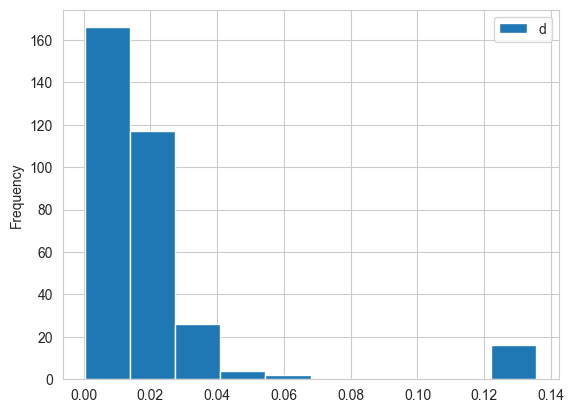

In [249]:
c_id = 6
c_data[c_data['cluster_id']==c_id].plot(y='d',kind='hist')

C:\Users\MishMish\AppData\Local\Temp\ipykernel_12404\3696714138.py:2: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.relplot(data=c_data, x='no2', y='co', hue='cluster_id', palette=c)


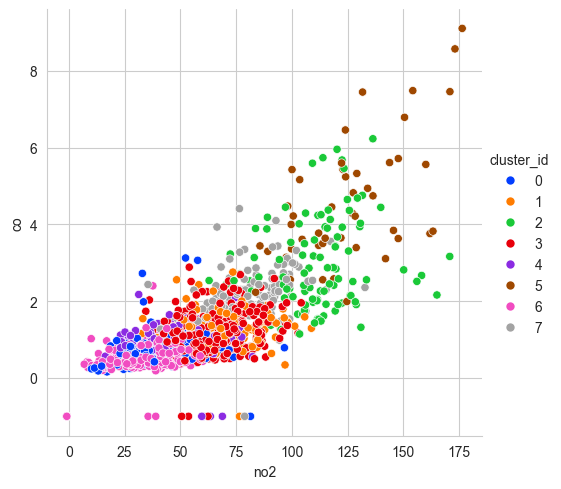

In [250]:
c = sns.color_palette("bright", as_cmap=True)
sns.relplot(data=c_data, x='no2', y='co', hue='cluster_id', palette=c)
plt.show()

In [256]:
c_data.groupby(lambda _: True).d.aggregate(['mean','std',p5,p90,p95,'count']).reset_index()

,index,mean,std,<lambda_0>,<lambda_1>,<lambda_2>,count
0,True,0.034688,0.045759,0.005143,0.071192,0.107252,1461


In [258]:
c_data[c_data['d']>0.07]

,date,pm2.5,pm10,so2,no2,co,o3,pm2.5_t,pm10_t,so2_t,no2_t,co_t,o3_t,cluster_id,d
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333,0.291988,0.337905,0.662829,0.754184,0.332172,0.353908,7,0.225930
5,2013-03-06,223.250000,265.166667,116.236700,142.059383,3.108348,19.750000,0.436886,0.486705,0.819056,0.806175,0.406401,0.105727,5,0.165535
6,2013-03-07,263.375000,316.083333,97.541667,147.750000,3.632875,38.833333,0.515058,0.579810,0.688446,0.838243,0.458288,0.202961,5,0.080744
7,2013-03-08,221.458333,297.958333,68.563026,118.835952,2.581455,79.333333,0.433396,0.546667,0.485991,0.675305,0.354281,0.409319,5,0.166939
10,2013-03-11,123.791667,178.291667,86.875000,90.666667,1.670750,75.250000,0.243120,0.327848,0.613925,0.516564,0.264193,0.388514,7,0.138170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,2017-01-03,292.458333,298.750000,20.125000,147.791667,5.717391,12.375000,0.571718,0.548114,0.147587,0.838478,0.664490,0.068149,5,0.148036
1405,2017-01-04,368.166667,381.333333,19.791667,170.958333,7.460870,9.375000,0.719214,0.699124,0.145258,0.969027,0.836957,0.052863,5,0.302557
1406,2017-01-05,219.041667,228.083333,11.958333,120.291667,5.958333,4.916667,0.428687,0.418895,0.090531,0.683508,0.688324,0.030147,2,0.107252
1429,2017-01-28,379.000000,435.166667,97.875000,83.750000,2.233333,64.041667,0.740320,0.797562,0.690775,0.477587,0.319844,0.331404,5,0.283637


In [278]:
# Doing the same with PCA - might be easier to visualize
# Targeting 90% explained variance
from sklearn.decomposition import PCA
var_target = 0.9
pca = PCA()
pca.fit(c_data[t_cols])

print(pca.explained_variance_ratio_)
n_comp = sum(pca.explained_variance_ratio_.cumsum() < 0.9) + 1
pca = PCA(n_components=n_comp).fit(c_data[t_cols])
pca_cols = ['pca_' + str(i+1) for i in range(n_comp)]

c_data[pca_cols] = pca.transform(c_data[t_cols])
c_data.head()

[0.58852861 0.25077568 0.08192689 0.04375956 0.02531031 0.00969896]


,date,pm2.5,pm10,so2,no2,co,o3,pm2.5_t,pm10_t,so2_t,no2_t,co_t,o3_t,cluster_id,d,pca_1,pca_2,pca_3,cluster_id_pca,d_pca
0,2013-03-01,7.125000,10.750000,11.708333,22.583333,0.429167,63.875000,0.015829,0.021486,0.088785,0.132898,0.141374,0.330555,6,0.011252,-0.295134,-0.100661,0.069342,6,0.015978
1,2013-03-02,30.750000,42.083333,36.625000,66.666667,0.824917,29.750000,0.061856,0.078781,0.262861,0.381318,0.180522,0.156679,3,0.035941,0.019098,-0.182715,0.128209,3,0.159420
2,2013-03-03,76.916667,120.541667,61.291667,81.000000,1.620625,19.125000,0.151798,0.222248,0.435191,0.462090,0.259234,0.102542,7,0.017614,0.263227,-0.133823,0.228975,7,0.179018
3,2013-03-04,22.708333,44.583333,22.869565,46.956522,0.617391,53.750000,0.046189,0.083352,0.166761,0.270247,0.159994,0.278965,6,0.020439,-0.132480,-0.095857,0.086555,6,0.012971
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333,0.291988,0.337905,0.662829,0.754184,0.332172,0.353908,7,0.225930,0.514699,0.214526,0.352351,7,0.393825


In [279]:
km_pca = KMeans() # The optimal number of clusters can be figured out. Arbitrary initialization - n=8 (sklearn default)
km_pca.fit(c_data[pca_cols])
c_data['cluster_id_pca'] = km_pca.labels_

In [280]:
# Computing distances from the respective centroids
dist = np.array(c_data[pca_cols] - km_pca.cluster_centers_[c_data.cluster_id_pca.tolist()])
dist = dist*dist
c_data['d_pca'] = dist.sum(axis=1)

In [284]:
c_data

,date,pm2.5,pm10,so2,no2,co,o3,pm2.5_t,pm10_t,so2_t,no2_t,co_t,o3_t,cluster_id,d,pca_1,pca_2,pca_3,cluster_id_pca,d_pca
0,2013-03-01,7.125000,10.750000,11.708333,22.583333,0.429167,63.875000,0.015829,0.021486,0.088785,0.132898,0.141374,0.330555,6,0.011252,-0.295134,-0.100661,0.069342,5,0.018496
1,2013-03-02,30.750000,42.083333,36.625000,66.666667,0.824917,29.750000,0.061856,0.078781,0.262861,0.381318,0.180522,0.156679,3,0.035941,0.019098,-0.182715,0.128209,6,0.030528
2,2013-03-03,76.916667,120.541667,61.291667,81.000000,1.620625,19.125000,0.151798,0.222248,0.435191,0.462090,0.259234,0.102542,7,0.017614,0.263227,-0.133823,0.228975,0,0.028507
3,2013-03-04,22.708333,44.583333,22.869565,46.956522,0.617391,53.750000,0.046189,0.083352,0.166761,0.270247,0.159994,0.278965,6,0.020439,-0.132480,-0.095857,0.086555,1,0.014405
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333,0.291988,0.337905,0.662829,0.754184,0.332172,0.353908,7,0.225930,0.514699,0.214526,0.352351,7,0.069441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-02-24,21.541667,32.625000,16.583333,58.875000,0.575000,50.791667,0.043916,0.061486,0.122843,0.337410,0.155800,0.263892,6,0.028980,-0.117616,-0.110316,0.027622,1,0.006681
1457,2017-02-25,11.208333,19.708333,6.750000,43.375000,0.420833,65.875000,0.023784,0.037867,0.054144,0.250064,0.140550,0.340745,6,0.012208,-0.240703,-0.070382,0.002726,5,0.007062
1458,2017-02-26,28.125000,40.708333,10.083333,65.375000,0.720833,48.625000,0.056742,0.076267,0.077432,0.374039,0.170226,0.252852,3,0.027088,-0.093136,-0.106215,-0.030477,1,0.010068
1459,2017-02-27,71.954545,94.863636,18.809524,98.000000,1.366667,35.272727,0.142131,0.175294,0.138396,0.557889,0.234113,0.184819,3,0.043795,0.147566,-0.076993,-0.058546,6,0.012498


In [281]:
c_data[['cluster_id','cluster_id_pca']].value_counts()

cluster_id  cluster_id_pca
3           6                 253
6           1                 210
1           4                 154
0           5                 133
4           2                 131
6           5                 121
7           0                 112
3           1                  75
2           3                  66
0           2                  59
2           0                  35
5           7                  31
0           4                  29
5           3                  16
3           4                  10
1           6                   9
7           7                   7
1           0                   6
7           6                   2
2           6                   1
            4                   1
Name: count, dtype: int64

C:\Users\MishMish\AppData\Local\Temp\ipykernel_12404\4079291944.py:2: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.relplot(data=c_data, x='pca_2', y='pm10', hue='cluster_id', palette=c)


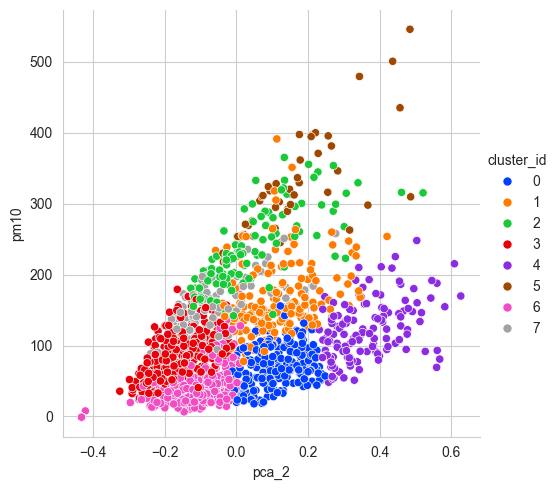

In [288]:
c = sns.color_palette("bright", as_cmap=True)
sns.relplot(data=c_data, x='pca_2', y='pm10', hue='cluster_id', palette=c)
plt.show()
# PCA appears to be segmenting somewhat better`

In [289]:
c_data.groupby(lambda _: True).d_pca.aggregate(['mean','std',p5,p90,p95,'count']).reset_index()

,index,mean,std,<lambda_0>,<lambda_1>,<lambda_2>,count
0,True,0.024278,0.037007,0.002139,0.052368,0.078278,1461


In [290]:
c_data[c_data['d_pca']>0.05]

,date,pm2.5,pm10,so2,no2,co,o3,pm2.5_t,pm10_t,so2_t,no2_t,co_t,o3_t,cluster_id,d,pca_1,pca_2,pca_3,cluster_id_pca,d_pca
4,2013-03-05,148.875000,183.791667,93.875000,132.833333,2.357958,68.458333,0.291988,0.337905,0.662829,0.754184,0.332172,0.353908,7,0.225930,0.514699,0.214526,0.352351,7,0.069441
7,2013-03-08,221.458333,297.958333,68.563026,118.835952,2.581455,79.333333,0.433396,0.546667,0.485991,0.675305,0.354281,0.409319,5,0.166939,0.543973,0.366975,0.173267,7,0.111189
10,2013-03-11,123.791667,178.291667,86.875000,90.666667,1.670750,75.250000,0.243120,0.327848,0.613925,0.516564,0.264193,0.388514,7,0.138170,0.314843,0.191053,0.389380,0,0.149790
13,2013-03-14,95.166667,107.291667,51.916667,70.375000,1.337292,68.916667,0.187353,0.198019,0.369694,0.402216,0.231207,0.356244,1,0.067110,0.100099,0.080276,0.211766,4,0.060731
14,2013-03-15,212.291667,250.625000,75.583333,99.416667,2.116500,44.208333,0.415537,0.460114,0.535038,0.565873,0.308287,0.230348,7,0.108362,0.520037,0.159285,0.242608,7,0.051537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,2017-01-02,173.833333,194.416667,13.666667,94.416667,3.083333,30.208333,0.340612,0.357333,0.102466,0.537696,0.403927,0.159015,2,0.025993,0.348784,0.035221,-0.146553,0,0.067130
1405,2017-01-04,368.166667,381.333333,19.791667,170.958333,7.460870,9.375000,0.719214,0.699124,0.145258,0.969027,0.836957,0.052863,5,0.302557,1.069398,0.265242,-0.353970,3,0.247776
1429,2017-01-28,379.000000,435.166667,97.875000,83.750000,2.233333,64.041667,0.740320,0.797562,0.690775,0.477587,0.319844,0.331404,5,0.283637,0.761705,0.456632,0.342752,7,0.124119
1436,2017-02-04,260.166667,262.833333,63.083333,114.958333,3.641667,66.333333,0.508808,0.482438,0.447708,0.653454,0.459158,0.343081,5,0.096329,0.586190,0.316154,0.124167,7,0.084433


### EDA - R5

Looking for anomalies which are violations of rules or common observations

In [292]:
# PM 2.5 concentrations should be lower than PM 10 always
(df_c['pm2.5'] > df_c['pm10']).sum()

np.int64(1183)

In [303]:
# PM10 concentrations should be correlated with the wind speed. In the absence of wind PM10 readings are higher
# https://www.researchgate.net/publication/341444279_Effect_of_wind_speed_on_the_level_of_particulate_matter_PM10_concentration_in_atmospheric_air_during_winter_season_in_vicinity_of_large_combustion_plant
p99 = lambda x: np.nanpercentile(x,99)
p90 = lambda x: np.nanpercentile(x,90)
p5 = lambda x: np.nanpercentile(x,5)

ws_mod = df_c['wspm'].fillna(-1).astype(int).apply(lambda x: 6 if x >= 6 else x) # Thresholding the wind speed values - higher values do not have a lot of data
df_c.groupby(ws_mod)['pm10'].aggregate(['mean','std','count',p5,p90,p99]).reset_index()

# While the observation about the concentrations is mostly true, the variance is higher with higher wind speeds

,wspm,mean,std,count,<lambda_0>,<lambda_1>,<lambda_2>
0,-1,109.500000,49.302442,14,32.2,162.3,180.18
1,0,130.834588,96.428860,9194,18.0,262.0,429.07
2,1,117.317051,97.034218,14351,14.0,245.0,451.50
3,2,85.364128,78.772591,5935,9.0,187.0,348.32
4,3,75.177539,76.924871,2796,8.0,171.0,362.15
5,4,83.558699,104.212803,1322,7.0,199.9,529.16
6,5,83.115914,104.744197,509,6.0,188.6,566.48
7,6,99.946222,140.888009,225,7.0,215.0,656.00


In [304]:
# PM 2.5 seasonality
# https://gero.usc.edu/airpollbrain-group/wp-content/uploads/2020/07/zhao..vanos-2018-1-s2.0-S1352231018305715-main.pdf
df_c.groupby('month')['pm2.5'].aggregate(['mean','std','count',p5,p90,p99]).reset_index()

,month,mean,std,count,<lambda_0>,<lambda_1>,<lambda_2>
0,1,92.817045,101.521091,2951,8.0,213.0,480.00
1,2,85.840645,100.386020,2667,5.3,222.4,456.00
2,3,99.999384,90.960768,2924,8.0,236.0,369.31
3,4,76.177490,57.394667,2741,9.0,156.0,243.00
4,5,67.340081,53.006691,2954,11.0,135.7,252.00
5,6,71.820177,59.476876,2825,8.0,152.0,268.52
6,7,75.256909,53.009309,2931,11.0,152.0,236.00
7,8,55.639271,43.209822,2908,8.0,118.0,182.00
8,9,64.456092,55.026122,2840,8.0,139.0,238.61
9,10,96.385923,94.451602,2941,6.0,253.0,361.60


### EDA - R6
Detecting latent patterns

In [321]:
covars = ['temp','pres','rain','dewp','wspm']

In [322]:
# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor

lof_df = df_c[pollutants+covars+['year','month','hour']].fillna(-1)
lof = LocalOutlierFactor(n_neighbors=120) # High number of neighbors to capture samples across both time and sensor variables
lof_df['lof_label'] = lof.fit_predict(lof_df)

In [323]:
lof_df[lof_df['lof_label']==-1]

,pm2.5,pm10,so2,no2,co,o3,temp,pres,rain,dewp,wspm,year,month,hour,lof_label
68,60.0,175.0,64.0,135.0,2.000,4.0,11.7,1013.5,0.0,-12.6,0.9,2013,3,20,-1
110,168.0,182.0,85.0,158.0,2.100,84.0,13.5,1007.7,0.0,-7.8,1.4,2013,3,14,-1
111,165.0,171.0,85.0,172.0,2.200,78.0,13.8,1007.2,0.0,-7.6,1.2,2013,3,15,-1
112,166.0,186.0,97.0,194.0,2.700,78.0,13.2,1007.1,0.0,-7.0,2.0,2013,3,16,-1
113,190.0,218.0,101.0,204.0,2.799,75.0,12.1,1007.7,0.0,-6.4,1.6,2013,3,17,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34362,126.0,130.0,28.0,43.0,0.900,133.0,-0.1,1029.7,0.0,-28.2,1.5,2017,1,18,-1
34372,98.0,98.0,32.0,42.0,1.200,133.0,-1.8,1025.8,0.0,-24.4,1.5,2017,1,4,-1
34742,3.0,5.0,57.0,118.0,3.000,64.0,7.3,1013.8,0.0,-6.1,1.2,2017,2,14,-1
34743,3.0,3.0,56.0,130.0,3.000,64.0,8.0,1012.8,0.0,-6.2,2.2,2017,2,15,-1


In [327]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

isof = IsolationForest(random_state=14)
isof_df = df_c[pollutan
ts+covars+['month','hour','wd_angle']].fillna(-1) # Not including year because the trend is not that significant
isof = isof.fit(isof_df)
isof_df['isof_label'] = isof.predict(isof_df)

In [328]:
isof_df['isof_label'].value_counts()
# The number's pretty high... Need to check

isof_label
 1    30897
-1     4167
Name: count, dtype: int64